# Market Basket Analysis Using Association Rules and PySpark



In [1]:
# Set the environment variable SPARK_LOCAL_HOSTNAME to localhost
%env SPARK_LOCAL_HOSTNAME=localhost
!pip install findspark
!pip install pyspark

# Importing necessary libraries
import findspark
findspark.init

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
import numpy as np
from pyspark.ml.fpm import FPGrowth



env: SPARK_LOCAL_HOSTNAME=localhost


In [4]:
# Create a Spark session
spark = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()
spark = SparkSession.Builder().appName('Project').getOrCreate()
sqlCtx = SQLContext(spark)


PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

## Data Preparation and Cleaning:

The dataset was loaded into a Spark DataFrame and underwent preprocessing steps such as filling missing values, removing rows with zero or negative quantities, and creating new columns for total price calculation.
Outlier detection using the IQR method was conducted, resulting in the identification and visualization of outliers using box plots.
Outliers were then handled using flooring and capping techniques to ensure the integrity of the data.

In [ ]:
# Read the CSV file into a Spark DataFrame
df_market = spark.read.csv('Market_Basket_Analysis_data.csv', header='true', inferSchema='true', sep=';')


In [ ]:
df_market.summary().show()

In [3]:
num_records = df_market.count()
print('Number of records: ', num_records)

NameError: name 'df_market' is not defined

In [7]:
# Fill missing values in the CustomerID column with 99999
df_market = df_market.fillna(99999, subset='CustomerID')

In [8]:
# Remove rows where Quantity is less than or equal to 0
df_market = df_market.filter(df_market.Quantity > 0)

In [9]:
# Drop rows with null values
df_market = df_market.dropna()

In [10]:
# Create a Total_Price column by multiplying Price and Quantity, and clean other fields
df_market = df_market.withColumn('Price', regexp_replace('Price', ',', '.'))
df_market = df_market.withColumn('Total_Price', round(df_market.Price * df_market.Quantity, 2))
df_market = df_market.withColumn('Hour', split('Date', ' ')[1])
df_market = df_market.withColumn('Date', split('Date', ' ')[0])
df_market = df_market.withColumn('Date', concat_ws('-', split('Date', '\\.')[2], split('Date', '\\.')[1], split('Date', '\\.')[0]))
df_market = df_market.withColumn('Date', to_date('Date'))


In [11]:
# Add a column for the product of Quantity and Price
df_market_price = df_market.withColumn("Quantity_times_Price", col("Quantity") * col("Price"))


In [12]:
# Round the Total_Price and Quantity_times_Price columns to 2 decimal places
df_market_price = df_market_price.withColumn("Total_Price_rounded", round(col("Total_Price"), 2))
df_market_price = df_market_price.withColumn("Quantity_times_Price_rounded", round(col("Quantity_times_Price"), 2))


In [13]:
df_market_price = df_market_price.withColumn("Price_times_Quantity_equals_Total_Price", col("Total_Price_rounded") == col("Quantity_times_Price_rounded"))


In [14]:
df_market_price = df_market_price.select("BillNo", "Quantity", "Price", "Total_Price_rounded", "Quantity_times_Price_rounded", "Price_times_Quantity_equals_Total_Price")


In [15]:
df_market_price.show()

+------+--------+-----+-------------------+----------------------------+---------------------------------------+
|BillNo|Quantity|Price|Total_Price_rounded|Quantity_times_Price_rounded|Price_times_Quantity_equals_Total_Price|
+------+--------+-----+-------------------+----------------------------+---------------------------------------+
|536365|       6| 2.55|               15.3|                        15.3|                                   true|
|536365|       6| 3.39|              20.34|                       20.34|                                   true|
|536365|       8| 2.75|               22.0|                        22.0|                                   true|
|536365|       6| 3.39|              20.34|                       20.34|                                   true|
|536365|       6| 3.39|              20.34|                       20.34|                                   true|
|536365|       2| 7.65|               15.3|                        15.3|                        

In [16]:
count = df_market_price.count()
print("Number of rows:", count)

Number of rows: 520136


In [17]:
# Outlier Detection using IQR method
quantiles = df_market.approxQuantile('Total_Price', [0.25, 0.75], 0.05)
q1 = quantiles[0]
q3 = quantiles[1]

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df_market.filter((df_market.Total_Price < lower_bound) | (df_market.Total_Price > upper_bound))

print("Total outliers ", outliers.count())


Total outliers  42211


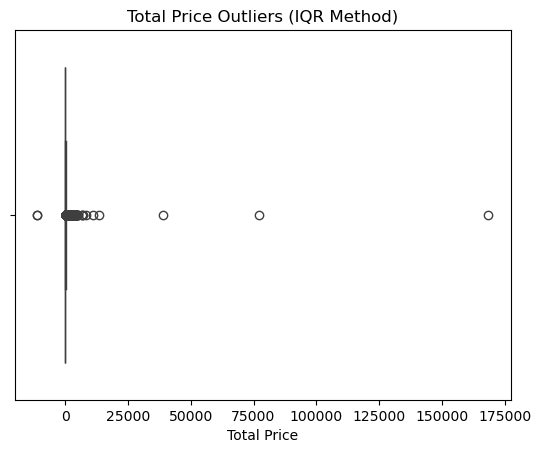

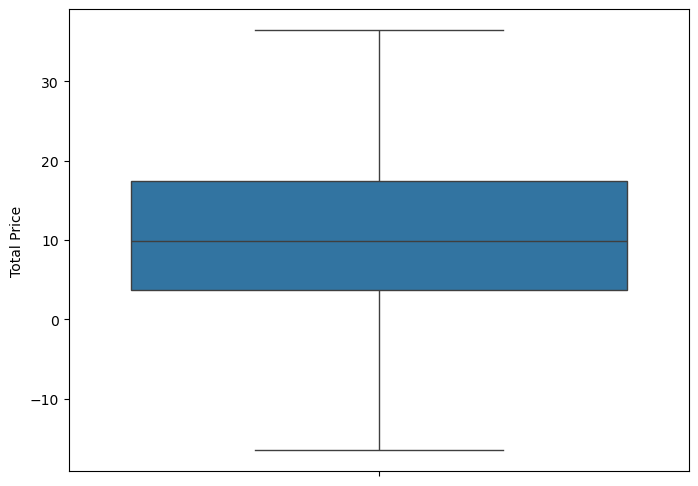

In [18]:
# Visualize outliers using a box plot
import matplotlib.pyplot as plt
import seaborn as sns

outliers_iqr_pd = outliers.select('Total_Price').toPandas()

sns.boxplot(x=outliers_iqr_pd['Total_Price'], orient='h')
plt.title('Total Price Outliers (IQR Method)')
plt.xlabel('Total Price')
plt.show()

# Floor and Cap outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_market = df_market.withColumn('Total_Price_Floor_Cap', when(df_market.Total_Price < lower_bound, lower_bound).when(df_market.Total_Price > upper_bound, upper_bound).otherwise(df_market.Total_Price))

# Visualize Total_Price after outlier removal
total_price_pd = df_market.select('Total_Price_Floor_Cap').toPandas()

plt.figure(figsize=(8, 6))
sns.boxplot(data=total_price_pd, y='Total_Price_Floor_Cap')
plt.ylabel('Total Price')
plt.show()

Observation : In the above code we have detected 42211 outliers in our dataset using IQR method. In order to eliminate detected outliers with upper and lowe cap values we decided to use flooring and capping method.

## Data Analysis:

The data was analyzed to find insights such as the top-selling products in each country and the total revenue earned by each country.
Visualizations were generated to illustrate total revenue by country and the distribution of expenses per customer.

In [19]:
# Group the data by country and item name, and compute the total quantity and total price of each item in each country
df_market.createOrReplaceTempView("df")
itemname_by_country = sqlCtx.sql("""SELECT Country, Itemname, SUM(Quantity) as Quantity, SUM(Total_Price) as Total_Price FROM df GROUP BY Country, Itemname""")
itemname_by_country.createOrReplaceTempView("itemname_by_country")

In [20]:
# Find the top-selling product (based on quantity) in each country
top_product_country = sqlCtx.sql("""SELECT Country, Itemname, Quantity FROM
    (SELECT Country, Itemname, Quantity, MAX(Quantity) OVER(PARTITION BY Country) AS Max_Quant FROM itemname_by_country)
    WHERE Quantity=MAX_Quant
    """)
# Print the top-selling products in each country
print("Best sellers by country")
top_product_country.orderBy('Quantity', ascending=False).show(40, truncate=False)

Best sellers by country
+--------------------+-----------------------------------+--------+
|Country             |Itemname                           |Quantity|
+--------------------+-----------------------------------+--------+
|United Kingdom      |PAPER CRAFT , LITTLE BIRDIE        |80995   |
|Netherlands         |RABBIT NIGHT LIGHT                 |4801    |
|France              |RABBIT NIGHT LIGHT                 |4024    |
|Japan               |RABBIT NIGHT LIGHT                 |3408    |
|Australia           |MINI PAINT SET VINTAGE             |2952    |
|Sweden              |MINI PAINT SET VINTAGE             |2916    |
|Germany             |ROUND SNACK BOXES SET OF4 WOODLAND |1233    |
|Spain               |CHILDRENS CUTLERY POLKADOT PINK    |729     |
|Switzerland         |PLASTERS IN TIN WOODLAND ANIMALS   |639     |
|Norway              |SMALL FOLDING SCISSOR(POINTED EDGE)|576     |
|Belgium             |PACK OF 72 RETROSPOT CAKE CASES    |480     |
|Singapore           |CH

In [21]:
# Calculate the total revenue (Total_Price) earned by each country
tot_price_by_country = sqlCtx.sql("""SELECT Country, ROUND(SUM(Total_Price), 2) AS Total_Price FROM itemname_by_country GROUP BY Country""")
print("Total gain by country")
tot_price_by_country_pd = tot_price_by_country.orderBy('Total_Price', ascending=False).toPandas()
tot_price_by_country_pd.head(40)


Total gain by country


,Country,Total_Price
0,United Kingdom,9003097.96
1,Netherlands,285446.34
2,Germany,228867.14
3,France,209715.11
4,Australia,138521.31
5,Spain,61577.11
6,Switzerland,57089.90
7,Belgium,41196.34
8,Sweden,38378.33
9,Japan,37416.37


## Visualization


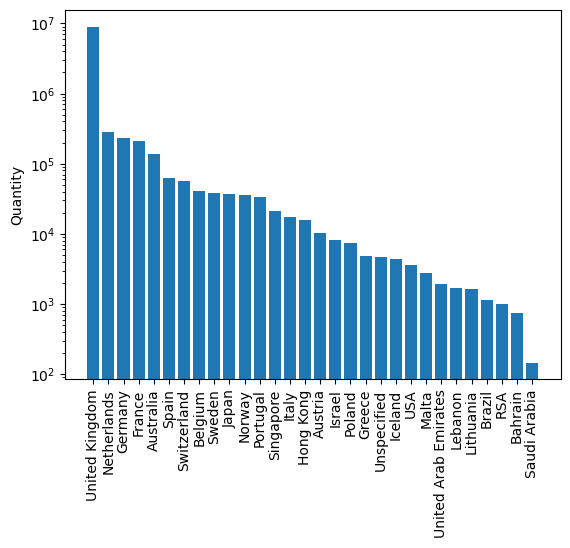

In [22]:
# Visualize total revenue by country
x = tot_price_by_country_pd['Country']
y = tot_price_by_country_pd['Total_Price']

plt.bar(x, y)
plt.yscale('log')
plt.ylabel('Quantity')
plt.xticks(rotation=90)
plt.show()

Observation: With a high level view the graph depicts to have a descending trend from highest revenue generated in United Kingdom to the least in Saudi Arabia.

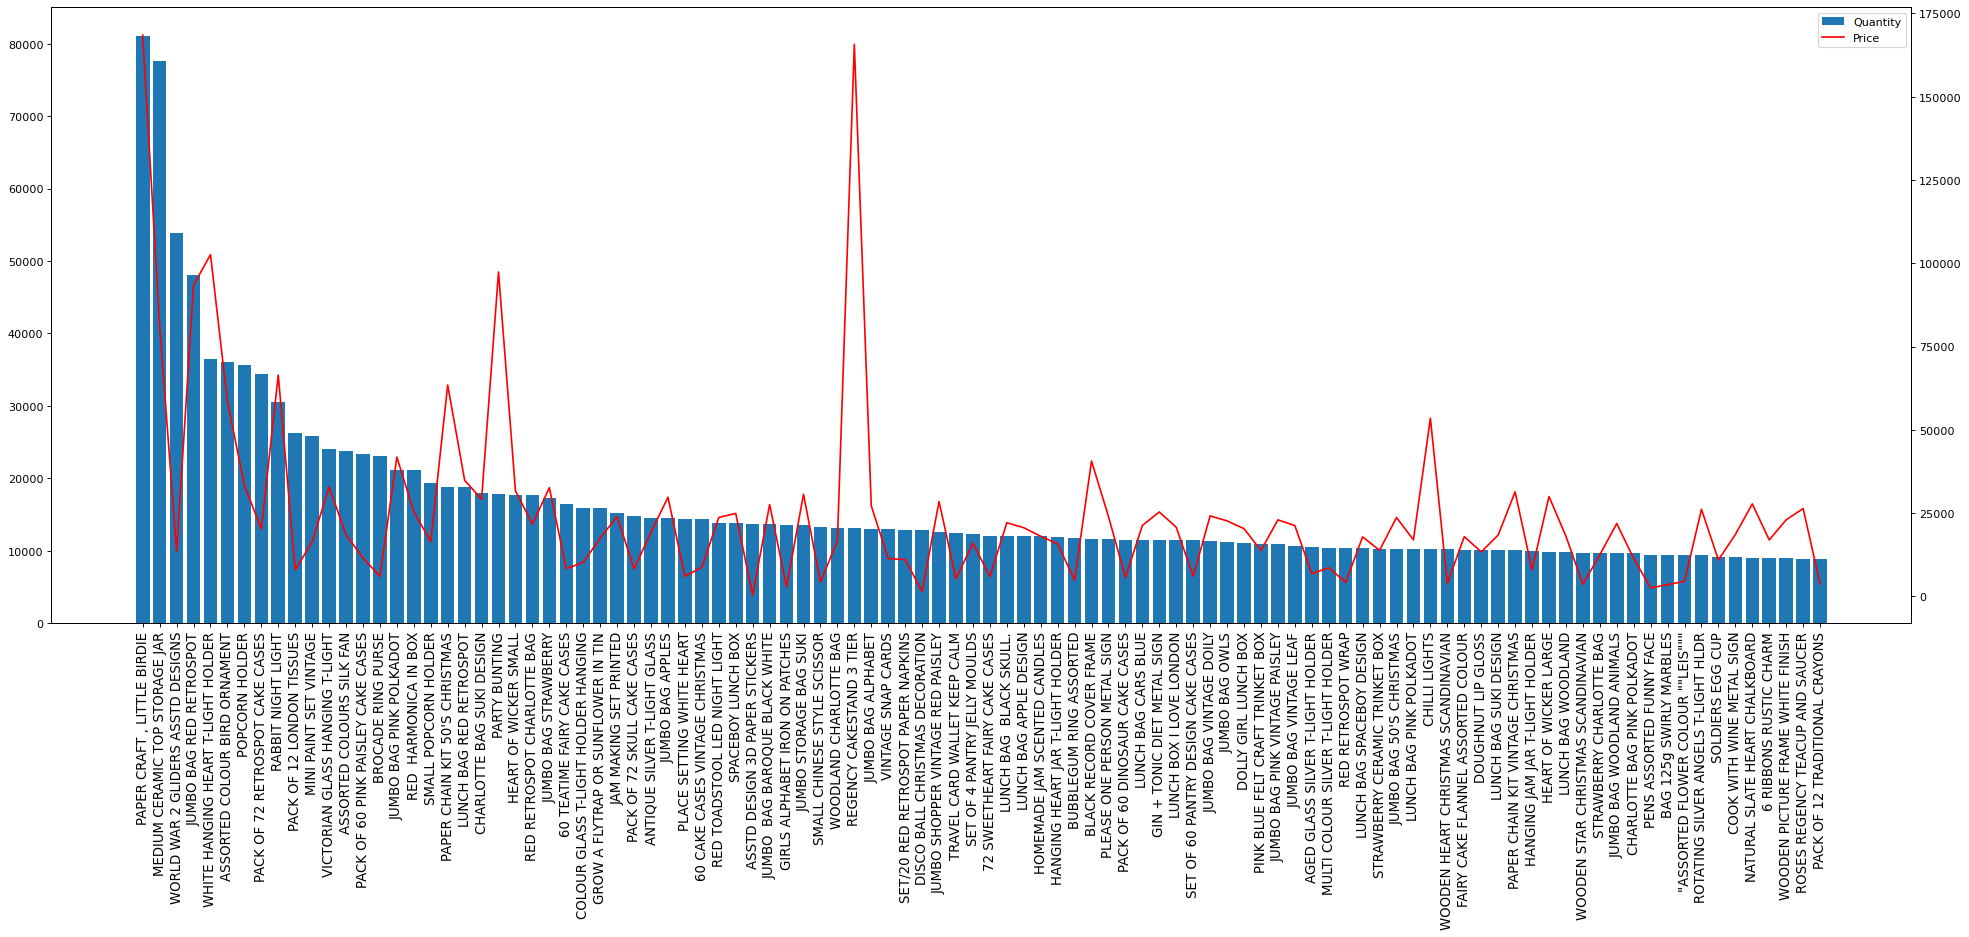

In [23]:
# Group items by quantity and total price
items_quantity = sqlCtx.sql("""SELECT Itemname, SUM(Quantity) as Quantity, SUM(Total_Price) as Total_Price FROM itemname_by_country GROUP BY Itemname""")
items_quantity_df = items_quantity.toPandas()

items_quantity_df = items_quantity_df.sort_values(by='Quantity', ascending=False)

ntop = 100

x = items_quantity_df['Itemname'][:ntop]
quant = items_quantity_df['Quantity'][:ntop]
price = items_quantity_df['Total_Price'][:ntop]
plt.figure(figsize=(30, 10), dpi=80)

ax1 = plt.subplot()
l1 = ax1.bar(x, quant, label='Quantity')
plt.xticks(rotation=90, fontsize=12)

ax2 = ax1.twinx()
l2, = ax2.plot(x, price, label='Price', color='r')
plt.legend([l1, l2], ["Quantity", "Price"])
plt.show()

Observation: From the given graph the bars represents Quantities of Items sold and the line represents Prices of items respectively. It can be depicted that the majority of represented items have equally low volume with respective prices except for a few items such as - PAPER CRAFT, LITTLE BIRDIE with high price, high quatity and REGENCY CAKESTAND 3 TIER with high price but low quatity.

C:\Users\umesh\AppData\Local\Temp\ipykernel_13428\1583370531.py:6: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot((np.log10(expense_per_customer_pd['Total_Price'][expense_per_customer_pd['Total_Price']>0])), bw=0.1, color='r')


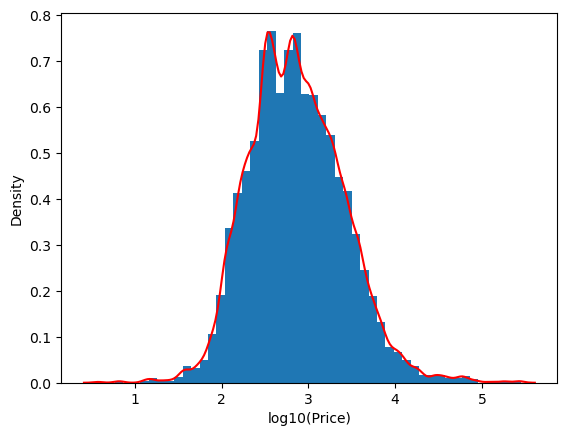

In [24]:
# Calculate and visualize the distribution of expenses per customer
expense_per_customer = sqlCtx.sql("""SELECT CustomerID, Country, SUM(Total_Price) as Total_Price FROM df WHERE CustomerID <> 99999 GROUP BY CustomerID, Country""")
expense_per_customer_pd = expense_per_customer.toPandas()

plt.hist(np.log10(expense_per_customer_pd['Total_Price'][expense_per_customer_pd['Total_Price']>0]), bins=50, density=True)
sns.kdeplot((np.log10(expense_per_customer_pd['Total_Price'][expense_per_customer_pd['Total_Price']>0])), bw=0.1, color='r')
plt.xlabel('log10(Price)')
plt.show()

From the graph above, we can infer with 2 peeks in log scale the graph is symmetrical on both ends.

# Apriori Analysis
- The Apriori algorithm was applied to mine association rules for a subset of countries, with specified minimum support and confidence thresholds.
- Association rules were examined to determine the number of countries in which they are present and the mean and minimum lift values.
- Additionally, the Apriori algorithm was executed for the entire dataset to identify association rules with significant lift values.

In [38]:
# Perform Apriori algorithm for the whole dataset
minSupport = 0.02
minConfidence = 0.4

# Instantiate the FP-Growth algorithm
apriori = FPGrowth(itemsCol="Itemname_vec", minSupport=minSupport, minConfidence=minConfidence)

# Fit the model to the dataset
model = apriori.fit(df_group)

# Extract the association rules
association_rules_apriori = model.associationRules

# Convert the association rules DataFrame to a Pandas DataFrame
association_rules_apriori_df = association_rules_apriori.toPandas()

# Specify the path where you want to save the CSV file
csv_file_path = "association_rules_apriori.csv"

# Save the association rules to a CSV file
association_rules_apriori_df.to_csv(csv_file_path, index=False)

print(f"Association rules have been saved to {csv_file_path}")
association_rules_apriori_df = association_rules_apriori_df.sort_values(by="lift", ascending=False)

print("Association rules Apriori - First 10 : ")
association_rules_apriori_df.head(10)



C:\Users\umesh\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
C:\Users\umesh\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):


Association rules have been saved to association_rules_apriori.csv
Association rules Apriori - First 10 : 


,antecedent,consequent,confidence,lift,support
112,"[GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",[PINK REGENCY TEACUP AND SAUCER],0.704514,18.890749,0.026096
101,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[GREEN REGENCY TEACUP AND SAUCER],0.903509,18.287944,0.026096
69,[GREEN REGENCY TEACUP AND SAUCER],[PINK REGENCY TEACUP AND SAUCER],0.620513,16.638343,0.030656
55,[PINK REGENCY TEACUP AND SAUCER],[GREEN REGENCY TEACUP AND SAUCER],0.822011,16.638343,0.030656
60,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[ROSES REGENCY TEACUP AND SAUCER],0.851240,16.583628,0.026096
10,[GARDENERS KNEELING PAD KEEP CALM],[GARDENERS KNEELING PAD CUP OF TEA],0.601105,15.733165,0.027565
103,[GARDENERS KNEELING PAD CUP OF TEA],[GARDENERS KNEELING PAD KEEP CALM],0.721485,15.733165,0.027565
54,[PINK REGENCY TEACUP AND SAUCER],[ROSES REGENCY TEACUP AND SAUCER],0.774457,15.087759,0.028883
31,[ROSES REGENCY TEACUP AND SAUCER],[PINK REGENCY TEACUP AND SAUCER],0.562685,15.087759,0.028883
68,[GREEN REGENCY TEACUP AND SAUCER],[ROSES REGENCY TEACUP AND SAUCER],0.749744,14.606308,0.037041


# FP-Growth algorithm
- The FP-Growth algorithm was utilized to extract frequent itemsets and association rules from the dataset.
- Frequent itemsets mined using FP-Growth were displayed, showcasing the items frequently purchased together.
- Association rules derived from FP-Growth provided further insights into item associations and purchasing patterns.

In [28]:
from pyspark.ml.fpm import FPGrowth

# Create an instance of the FP-Growth algorithm
fp_growth = FPGrowth(itemsCol="Itemname_vec", minSupport=0.02, minConfidence=0.04)

# Fit the FP-Growth model to the dataset
model_fpgrowth = fp_growth.fit(df_group)

# Extract the frequent itemsets from the model
frequent_itemsets = model_fpgrowth.freqItemsets

# Display and save frequent itemsets to CSV
print("Frequent Itemsets Mined using FP-Growth Algorithm:")
frequent_itemsets.show(truncate=False)
# frequent_itemsets.toPandas().to_csv("frequent_itemsets.csv", index=False)

# Extract the association rules from the model
association_rules_fpgrowth = model_fpgrowth.associationRules

# Display and save association rules to CSV
# print("Association Rules Mined using FP-Growth Algorithm:")
# association_rules_fpgrowth.show(truncate=False)
association_rules_fpgrowth.toPandas().to_csv("association_rules_fpgrowth.csv", index=False)
# Load association rules from CSV into a Pandas DataFrame
association_rules_fpgrowth_df = pd.read_csv("association_rules_fpgrowth.csv")
association_rules_fpgrowth_df = association_rules_fpgrowth_df.sort_values(by="lift", ascending=False)

# Display the association rules DataFrame
print("Association rules FP-Growth - First 10 : ")
association_rules_fpgrowth_df.head(10)


Frequent Itemsets Mined using FP-Growth Algorithm:
+--------------------------------------------------------------+----+
|items                                                         |freq|
+--------------------------------------------------------------+----+
|[JUMBO BAG VINTAGE CHRISTMAS]                                 |470 |
|[SET OF 20 VINTAGE CHRISTMAS NAPKINS]                         |590 |
|[JUMBO BAG SCANDINAVIAN BLUE PAISLEY]                         |656 |
|[JUMBO BAG SCANDINAVIAN BLUE PAISLEY, JUMBO BAG RED RETROSPOT]|443 |
|[JUMBO BAG DOILEY PATTERNS]                                   |510 |
|[RABBIT NIGHT LIGHT]                                          |979 |
|[LUNCH BAG  BLACK SKULL.]                                     |1260|
|[LUNCH BAG  BLACK SKULL., LUNCH BAG RED RETROSPOT]            |632 |
|[STRAWBERRY CHARLOTTE BAG]                                    |716 |
|[STRAWBERRY CHARLOTTE BAG, WOODLAND CHARLOTTE BAG]            |404 |
|[STRAWBERRY CHARLOTTE BAG, RED RETROSP

,antecedent,consequent,confidence,lift,support
165,"['GREEN REGENCY TEACUP AND SAUCER', 'ROSES REG...",['PINK REGENCY TEACUP AND SAUCER'],0.704514,18.890749,0.026096
152,"['PINK REGENCY TEACUP AND SAUCER', 'ROSES REGE...",['GREEN REGENCY TEACUP AND SAUCER'],0.903509,18.287944,0.026096
114,['GREEN REGENCY TEACUP AND SAUCER'],['PINK REGENCY TEACUP AND SAUCER'],0.620513,16.638343,0.030656
95,['PINK REGENCY TEACUP AND SAUCER'],['GREEN REGENCY TEACUP AND SAUCER'],0.822011,16.638343,0.030656
102,"['PINK REGENCY TEACUP AND SAUCER', 'GREEN REGE...",['ROSES REGENCY TEACUP AND SAUCER'],0.851240,16.583628,0.026096
13,['GARDENERS KNEELING PAD KEEP CALM'],['GARDENERS KNEELING PAD CUP OF TEA'],0.601105,15.733165,0.027565
156,['GARDENERS KNEELING PAD CUP OF TEA'],['GARDENERS KNEELING PAD KEEP CALM'],0.721485,15.733165,0.027565
94,['PINK REGENCY TEACUP AND SAUCER'],['ROSES REGENCY TEACUP AND SAUCER'],0.774457,15.087759,0.028883
65,['ROSES REGENCY TEACUP AND SAUCER'],['PINK REGENCY TEACUP AND SAUCER'],0.562685,15.087759,0.028883
113,['GREEN REGENCY TEACUP AND SAUCER'],['ROSES REGENCY TEACUP AND SAUCER'],0.749744,14.606308,0.037041


# Comments:
- The preprocessing steps effectively cleaned the dataset, ensuring its suitability for subsequent analysis and modeling.
- Outlier detection and handling techniques were essential for maintaining data integrity and reliability.
- The analysis revealed valuable insights into customer purchasing behaviors, top-selling products, and revenue generation across different countries.
- Both the Apriori and FP-Growth algorithms were employed to extract association rules, uncovering meaningful relationships between items in transactions.
- Visualizations aided in the interpretation of results and provided intuitive representations of key findings.

In [29]:
# Define the function to plot association rules with support
def plot_association_rules(rules_df, algorithm_name):
    top_rules = rules_df.limit(10).toPandas()  # Consider top 10 rules for visualization
    x = range(len(top_rules))

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # Plot for lift
    axs[0].bar(x, top_rules['lift'], color='blue')
    axs[0].set_title(f'Top 10 Association Rules by Lift ({algorithm_name})')
    axs[0].set_xlabel('Association Rule')
    axs[0].set_ylabel('Lift')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels([f"{antecedent} => {consequent}" for antecedent, consequent in zip(top_rules['antecedent'], top_rules['consequent'])], rotation=90)

    # Plot for confidence
    axs[1].bar(x, top_rules['confidence'], color='green')
    axs[1].set_title(f'Top 10 Association Rules by Confidence ({algorithm_name})')
    axs[1].set_xlabel('Association Rule')
    axs[1].set_ylabel('Confidence')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels([f"{antecedent} => {consequent}" for antecedent, consequent in zip(top_rules['antecedent'], top_rules['consequent'])], rotation=90)

    # Plot for support
    axs[2].bar(x, top_rules['support'], color='orange')
    axs[2].set_title(f'Top 10 Association Rules by Support ({algorithm_name})')
    axs[2].set_xlabel('Association Rule')
    axs[2].set_ylabel('Support')
    axs[2].set_xticks(x)
    axs[2].set_xticklabels([f"{antecedent} => {consequent}" for antecedent, consequent in zip(top_rules['antecedent'], top_rules['consequent'])], rotation=90)

    plt.tight_layout()
    plt.show()

# Plot association rules with support for Apriori
plot_association_rules(apriori, "Apriori")

# Plot association rules with support for FP-Growth
plot_association_rules(results, "FP-Growth")


AttributeError: 'FPGrowth' object has no attribute 'limit'

# Result of Analysis:

By comparing the results using two methods - Apriori and FP Growth following observations are made for each characteristics:

- Lift : Association appears to be higher in FP growth than Apriori
- Confidence : appears to be more favourable in Apriori than FP **growth**
- Support : appears to be dominant in Apriori than in FP growth

### Why Apriori for Market Basket Analysis using Spark on top of FP Growth Association Rule ?

Both association rules are equally preferred, however in some scenarios Apriori Rules over FP Growth due to following reasons :

*   **Interpretability**: The if-then structure that Apriori uses to build association rules makes them simple to comprehend.
*   **Small to Medium-Sized Datasets** :  Apriori works well with datasets with a manageable number of items and transactions that fit into memory.
*   **Simplicity in Parameter Tuning** : Apriori simplifies the procedure with fewer parameters to adjust, particularly when threshold sets are guided by domain knowledge.
*   **Explicit Candidate Generation**: The methodical approach to candidate generation by Apriori offers insights into dataset relationships and algorithm behaviour.
*   **Preference for Rule Generation**: For a more detailed understanding, analysts might like Apriori's method of explicitly creating all frequent itemsets and association rules.

However, it's important to remember that FP-Growth has advantages in terms of efficiency and scalability, particularly when working with huge datasets that have high-dimensional itemsets. Various criteria, including dataset size, processing resources, interpretability requirements, and analysis aims, influence the decision between Apriori and FP-Growth.









## Future Work

*   **Visualization and Interpretation**: Develop interactive and visually appealing dashboards to present the results of the market basket analysis, allowing stakeholders to explore the association rules interactively and gain insights more intuitively.

*   **Integration with Recommendation Systems**: Integrate the association rules generated from market basket analysis into recommendation systems to provide personalized product recommendations to customers based on their purchasing history and preferences.
Experiment with collaborative filtering techniques and hybrid recommendation approaches to enhance the accuracy and relevance of product recommendations.
*   **Real-Time Analysis and Deployment**: Explore real-time market basket analysis by integrating streaming data sources and deploying the analysis pipeline in a production environment.
Implement automated model updating and retraining mechanisms to adapt to changes in customer behavior and market dynamics over time.





